In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
from Funcs import advance_adv_diff_RK3
from fluid_flow import advance_fluid_flow, set_boundary

In [3]:
# Note: this is dangerous since we don't know what we import, but it's a lazy 
# and definitely the most compact way to get all constants:
from parameters import *
# Just make sure to put only global constants in that file, which are not going to be
# confused with parameters that are susceptible to change, such as resolution

In [4]:
# initial setup of velocity field
u0 = np.zeros((N,M))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0)

u, v = np.copy(u0), np.copy(v0)

In [10]:
dt = 1e-7
Nt = 1000
# loop over given number of iterations 
# (note: the first time this line is executed it takes long since numba needs to compile a lot):
%time u, v = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt)

CPU times: user 555 ms, sys: 65 µs, total: 555 ms
Wall time: 554 ms


Text(0, 0.5, '$y$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
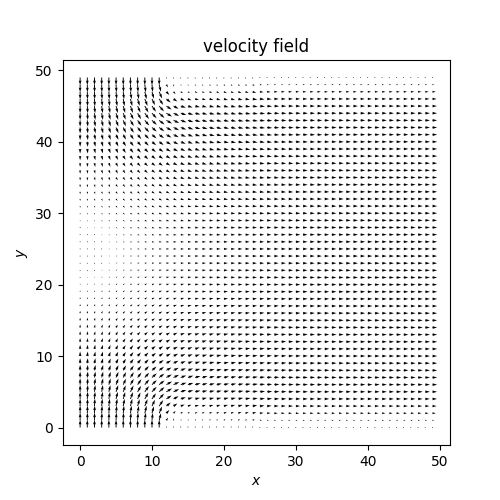

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
ax.quiver(u.T, v.T)
ax.set_title('velocity field')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
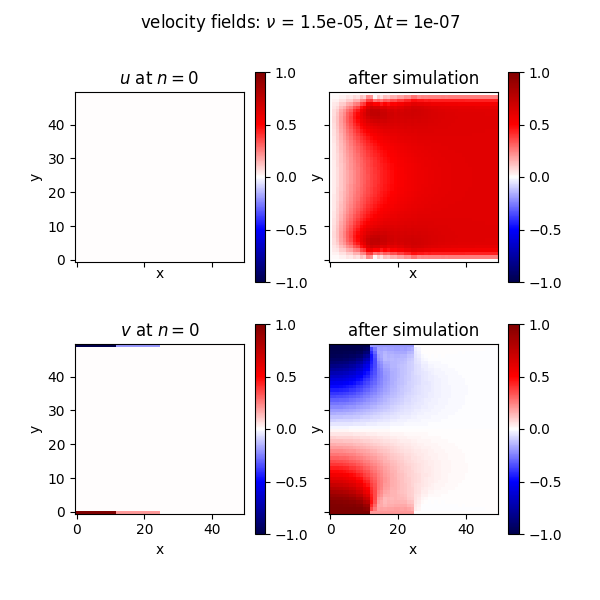

In [12]:
fig, axs=plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
#[ax1,ax2,ax3,ax4] = axs.flatten()

U  = np.array([u,v])
U0 = np.array([u0,v0])
umax = np.max(np.abs(U))

for i in [0,1]:
    [ax1, ax2] = axs[i,:]
    
    im1=ax1.imshow(U0[i].T, cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # first frame
    im2=ax2.imshow(U[i].T , cmap='seismic', vmax=umax, vmin=-umax, origin='lower') # last frame
    
    s = '$u$' if i==0 else '$v$'
    fig.colorbar(im1, ax=ax1)
    ax1.set_title("{} at $n=0$".format(s))
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    #im2=ax2.imshow(np.abs(vres[numplot]).T)
    fig.colorbar(im2, ax=ax2)
    ax2.set_title(r"after simulation")
    fig.suptitle(r'velocity fields: $\nu$ = {}, $\Delta t=${}'.format(nu,dt))
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    #fig.set_size_inches(15,5)

    #plt.savefig("img_dt={}_nu={}, flow_rate={}.jpg".format(dt,nu,flow))


**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [9]:
from Funcs import df1_2
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1527.7305819329747


In [14]:
from pathlib import Path
datap = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
np.save(datap, np.array([u,v]))